In [1]:
#### Notes on how to read the data

# Tuning experiments:
    # tuned_dyn_cas_bin: irace with binning and cascading

# Baselines:
    # theory_dyn: policy from theory (using formula)
    # optimal_dyn: (near-)optimal policy calculated by CMA-ES
    # optimal_dyn_bin: (near-)optimal binned policy calculated by CMA-ES (#bins=ceil(log2(n)) where n is the problem size)
    # binned_theory_dyn_<start/middle/end>: binned version of theory_dyn where lbd is chosen at the start/middle/end of each bin

# Columns in dataframe:
    # n: problem size
    # experiment: theory_dyn, tuned_dyn_cas_bin, etc
    # tuning_budget: #runs (i.e., #episodes) of the OLL algorithm during each tuning.
    # best_configuration: the best configuration found by the corresponding experiment, read based on two arrays (fx and lbd) as follows:
        # lbd[i] is the best lbd value for all objective values o where fx[i] <= o < fx[i+1] (note that for the last value of i, fx[i+1]=n)
    # evaluation_results: performance of best_configuration over 500 runs

import pandas as pd
import scipy
import numpy as np
import ast

t = pd.read_csv("results.csv")

def ttest(t, conf1, conf2):
    val1 = ast.literal_eval(t[t.experiment==conf1]["evaluation_results"].values[0])
    val2 = ast.literal_eval(t[t.experiment.str.contains(conf2)]["evaluation_results"].values[0])
    pval = scipy.stats.ranksums(val1, val2).pvalue
    return pval, np.mean(val1), np.mean(val2)

tstat = t[(t.n>=500) & (t.n<=3000)]
display(tstat.experiment.unique())

ls_n = tstat.n.unique()
ls_n.sort()
for n in ls_n:
    pvalue, mean1, mean2 = ttest(tstat[tstat.n==n], 'theory_dyn', 'tuned_dyn_cas_bin')
    # p-value (<=0.05 means statistically significant), mean runtime of theory_dyn, mean runtime of irace's results
    print(f"n: {n}, theory_dyn vs tuned_dyn_cas_bin: {pvalue*3:.2}, {mean1}, {mean2} ")

array(['tuned_dyn_cas_bin', 'theory_dyn', 'optimal_dyn',
       'optimal_dyn_bin'], dtype=object)

n: 500, theory_dyn vs tuned_dyn_cas_bin: 0.31, 3227.896, 3254.794 
n: 1000, theory_dyn vs tuned_dyn_cas_bin: 0.0008, 6605.074, 6487.806 
n: 2000, theory_dyn vs tuned_dyn_cas_bin: 3.8e-27, 13315.528, 12748.334 
n: 3000, theory_dyn vs tuned_dyn_cas_bin: 8.8e-27, 20128.966, 19417.278 


theory_dyn > tuned_dyn_cas_bin: 355
theory_dyn = tuned_dyn_cas_bin: 1
theory_dyn < tuned_dyn_cas_bin: 144


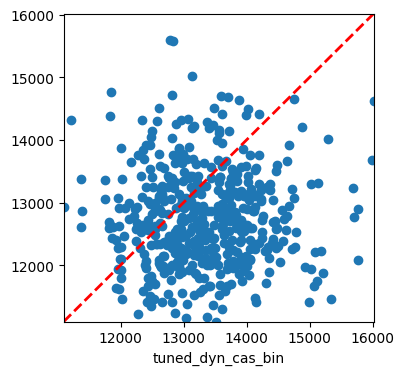

In [61]:
# visualisation using scatter plot

import matplotlib.pyplot as plt

n = 2000
x = ast.literal_eval(t[(t.n==n) & (t.experiment=="theory_dyn")]["evaluation_results"].values[0])
y = ast.literal_eval(t[(t.n==n) & t.experiment.str.contains("tuned_dyn_cas_bin")]["evaluation_results"].values[0])
plt.figure(figsize=(4,4))
plt.scatter(x=x, y=y)
max_range = max(max(x), max(y))
min_range = min(min(x), min(y))
plt.xlim(min_range, max_range)
plt.ylim(min_range, max_range)
plt.xlabel("theory_dyn")
plt.xlabel("tuned_dyn_cas_bin")

# Plot the diagonal line
plt.plot([min_range, max_range], [min_range, max_range], color='red', linestyle='--', linewidth=2, label="Diagonal Line")

# Convert inputs to numpy arrays for easy comparison
x = np.array(x)
y = np.array(y)

# Perform element-wise comparison and count the True values
print(f"theory_dyn > tuned_dyn_cas_bin: {sum(x > y)}")
print(f"theory_dyn = tuned_dyn_cas_bin: {sum(x == y)}")
print(f"theory_dyn < tuned_dyn_cas_bin: {sum(x < y)}")

In [62]:
# statistical test functions
import scipy

def statistical_test(x, y, rank=False, paired=True, alternative="two-sided"):
    # x, y: two numerical arrays of the same lengths (e.g., each array represent performance of an algorithm across different random seeds)
    # rank: use ranked test (Wilcoxon) or ttest. If ttest is used, the magnitude of the performance difference is taken into account. Default: False (ttest)
    # paired: whether each sample in the two arrays x and y are paired (e.g., two runs of the same random seeds). Default: True
    # alternative: 
    #   "two-sided": test whether the two arrays are different
    #   "less": test whether values in x is significantly better than y (minimisation)
    #   "greater": test whether values in x is significantly worse than y (minimisation)
    # RETURN: p-value, if p-value < 0.05, we often say that result is statistically significant
    if rank is False:
        if paired:
            _, p = scipy.stats.mstats.ttest_rel(x,y,axis=None, alternative=alternative)
        else:
            _, p = scipy.stats.mstats.ttest_ind(x,y,axis=None,equal_var=False, alternative=alternative)
    else:
        if paired:
            _, p = scipy.stats.wilcoxon(x, y, axis=None, alternative=alternative)
        else:
            _, p = scipy.stats.mannwhitneyu(x, y, axis=None, alternative=alternative)
    return p


##### EXAMPLE: compare theory_dyn and irace's results on n=2000

n = 2000

# get results of theory_dyn and irace
x = ast.literal_eval(t[(t.n==n) & (t.experiment=="theory_dyn")]["evaluation_results"].values[0])
y = ast.literal_eval(t[(t.n==n) & t.experiment.str.contains("tuned_dyn_cas_bin")]["evaluation_results"].values[0])

# mean performance
print(f"mean(x): {np.mean(x)}, mean(y): {np.mean(y)}")

# various statistical tests

# paired ttest
p = statistical_test(x, y, rank=False, paired=True, alternative="two-sided")
print(f"paired ttest, x!=y: {p}") # theory_dyn is statistically significantly different from tuned_dyn_cas_bin
p = statistical_test(x, y, rank=False, paired=True, alternative="greater")
print(f"paired ttest, x>y: {p}") # theory_dyn is statistically significantly worse than tuned_dyn_cas_bin (since we're minimising runtime)
p = statistical_test(x, y, rank=False, paired=True, alternative="less")
print(f"paired ttest, x<y: {p}") # theory_dyn is NOT statistically significantly better than tuned_dyn_cas_bin

print("")

# non-paired ttest
p = statistical_test(x, y, rank=False, paired=False, alternative="two-sided")
print(f"paired ttest, x!=y: {p}") # theory_dyn is statistically significantly different from tuned_dyn_cas_bin
p = statistical_test(x, y, rank=False, paired=False, alternative="greater")
print(f"paired ttest, x>y: {p}") # theory_dyn is statistically significantly worse than tuned_dyn_cas_bin (assuming we're minimising runtime)
p = statistical_test(x, y, rank=False, paired=False, alternative="less")
print(f"paired ttest, x<y: {p}") # theory_dyn is NOT statistically significantly better than tuned_dyn_cas_bin (assuming we're minimising runtime)

print("")

# paired rank-sum test
p = statistical_test(x, y, rank=True, paired=True, alternative="two-sided")
print(f"paired ttest, x!=y: {p}") # theory_dyn is statistically significantly different from tuned_dyn_cas_bin
p = statistical_test(x, y, rank=True, paired=True, alternative="greater")
print(f"paired ttest, x>y: {p}") # theory_dyn is statistically significantly worse than tuned_dyn_cas_bin (since we're minimising runtime)
p = statistical_test(x, y, rank=True, paired=True, alternative="less")
print(f"paired ttest, x<y: {p}") # theory_dyn is NOT statistically significantly better than tuned_dyn_cas_bin


mean(x): 13315.528, mean(y): 12748.334
paired ttest, x!=y: 6.36456509216563e-27
paired ttest, x>y: 3.182282546082815e-27
paired ttest, x<y: 1.0

paired ttest, x!=y: 7.733307350839333e-28
paired ttest, x>y: 3.8666536754196663e-28
paired ttest, x<y: 1.0

paired ttest, x!=y: 5.551202538562415e-26
paired ttest, x>y: 2.7756012692812073e-26
paired ttest, x<y: 1.0
